In [62]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Layer
from tensorflow.keras.models import Model, load_model

from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
import shap
from collections import defaultdict
import itertools
import logging
import time

In [63]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [2]:
# load and preprocess data: cali housing

cali_housing_path = '../data/California_Houses.csv'
RANDOM_SEED = 492
cali_df = pd.read_csv(cali_housing_path)
y_series = cali_df['Median_House_Value']
y = pd.DataFrame(y_series, columns=['Median_House_Value'])
features = [col for col in cali_df.columns if col != 'Median_House_Value']
X = cali_df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# preprocessing

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [3]:
# make the data into strings
X_train_texts = X_train_scaled.astype(str).apply(' '.join, axis=1).tolist()
X_test_texts = X_test_scaled.astype(str).apply(' '.join, axis=1).tolist()

In [4]:
# Load the pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [71]:
class IntegratedGradients:
    def __init__(self, model, input_shape, baseline=None, num_steps=50):
        self.model = model
        self.input_shape = input_shape
        self.baseline = baseline if baseline is not None else tf.zeros(input_shape)
        self.num_steps = num_steps

    def compute_gradients(self, inputs):
        gradients = []
        for step in range(self.num_steps + 1):
            alpha = step / self.num_steps
            interpolated_input = self.baseline + alpha * (inputs - self.baseline)
            with tf.GradientTape() as tape:
                tape.watch(interpolated_input)
                output = self.model(interpolated_input, training=False)
            gradients.append(tape.gradient(output, interpolated_input))
        
        avg_gradients = tf.reduce_mean(tf.stack(gradients, axis=0), axis=0)
        integrated_gradients = (inputs - self.baseline) * avg_gradients / self.num_steps
        return integrated_gradients

In [85]:
class BERTRegression(Model):
    def __init__(self, max_length, dense_size, dropout_rate=0.1, num_mc_samples=10, num_features=13):
        super(BERTRegression, self).__init__()
        self.max_length = max_length
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')
        self.bert_model.trainable = True
        self.dropout = Dropout(dropout_rate)
        self.dense_layer = Dense(dense_size, activation='relu')
        self.mc_dropout = Dropout(dropout_rate)
        self.output_layer = Dense(1, activation='linear')
        self.num_mc_samples = num_mc_samples
        self.num_features = num_features
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.lime_explainer = LimeTextExplainer(
            class_names=['Median_Income', 'Median_Age', 'Tot_Rooms', 
                         'Tot_Bedrooms', 'Population', 'Households', 
                         'Latitude', 'Longitude', 'Distance_to_coast', 'Distance_to_LA']
        )
        
    def call(self, inputs, training=True):
        input_ids, attention_mask, token_type_ids = inputs
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[1]
        dropout_output = self.dropout(bert_output, training=training)
        hidden_output = self.dense_layer(dropout_output)
        mc_dropout_output = self.mc_dropout(hidden_output, training=training)
        output = self.output_layer(mc_dropout_output)
        return output
    
    def predict_with_uncertainty(self, inputs):
        output_compile = []
        for _ in range(self.num_mc_samples): 
            sample_output = self(inputs, training=True)
            output_compile.append(sample_output)
        output_compile = tf.stack(output_compile, axis=0)
        output_mean = tf.reduce_mean(output_compile, axis=0)
        output_sd = tf.math.reduce_std(output_compile, axis=0)
        return output_mean.numpy(), output_sd.numpy()

    def explain_lime(self, text_instance):
        explanations = []
    
        # Tokenize and encode the text instance once
        encoded_instance = self.tokenizer.batch_encode_plus(
            text_instance,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        input_ids = encoded_instance['input_ids']
        attention_mask = encoded_instance['attention_mask']
        token_type_ids = encoded_instance.get('token_type_ids', None)
    
        if token_type_ids is not None:
            inputs = [input_ids, attention_mask, token_type_ids]
        else:
            inputs = [input_ids, attention_mask]

        def predict_function(inputs):
            # Model output should be converted to numpy
            predictions = self(inputs, training=True).numpy()
            return predictions.flatten()  # Flatten the predictions if they are in (batch_size, 1) format
    
        all_predictions = predict_function(inputs)
        
        logging.info("Starting LIME explanations")
        start_time = time.time()
        for i in range(self.num_mc_samples):
            logging.info(f"Explaining instance {i+1}/{self.num_mc_samples}")
            single_prediction = all_predictions[i]
            single_prediction = np.array(single_prediction).flatten()  # Flatten for LIME
            exp = self.lime_explainer.explain_instance(
                text_instance,
                lambda x: single_prediction.flatten(),  # Use single prediction
                num_features=self.num_features
            )
            explanations.append(exp)
            logging.info(f"LIME Explanation {i+1}/{self.num_mc_samples} completed in {time.time() - start_time:.2f} seconds")
        
        logging.info(f"All LIME explanations completed in {time.time() - start_time:.2f} seconds")
        return explanations
    
    def explain_ig(self, text_instance):
      # Tokenize and encode the text instance once
        encoded_instance = self.tokenizer.batch_encode_plus(
            text_instance,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        input_ids = encoded_instance['input_ids']
        attention_mask = encoded_instance['attention_mask']
        token_type_ids = encoded_instance.get('token_type_ids', None)
    
        if token_type_ids is not None:
            inputs = [input_ids, attention_mask, token_type_ids]
        else:
            inputs = [input_ids, attention_mask]

        def predict_function(inputs):
            # Model output should be converted to numpy
            predictions = self(inputs, training=True).numpy()
            return predictions.flatten()  # Flatten the predictions if they are in (batch_size, 1) format
    
        all_predictions = predict_function(inputs)
    
        explanations = []
        individual_explanations = []
        logging.info("Starting IG explanations")
        start_time = time.time()
        for i in range(self.num_mc_samples):
            logging.info(f"Explaining instance {i+1}/{self.num_mc_samples}")
            single_prediction = all_predictions[i]
            # Use explain_ig on the model and the current prediction
            ig_explanation = IntegratedGradients(self.model,  # Pass the actual model
                                                 encoded_instance['input_ids'].shape[1:]  # Assuming input_ids defines the shape
                                                 ).compute_gradients(single_prediction)
            explanations.append(ig_explanation)
            individual_explanations.append(ig_explanation)
    
            logging.info(f"IG Explanation {i+1}/{self.num_mc_samples} completed in {time.time() - start_time:.2f} seconds")
    
        logging.info(f"All IG explanations completed in {time.time() - start_time:.2f} seconds")
    
        # Calculate mean and standard deviation of explanations
        explanation_means = np.mean(individual_explanations, axis=0)
        explanation_stds = np.std(individual_explanations, axis=0)
    
        return explanations, explanation_means, explanation_stds

In [6]:
# set values
max_length = 230
dense_size = 55
dropout_rate = 0.1
num_mc_samples = 50
num_features = 13

In [80]:
# Initialize model
berty = BERTRegression(max_length, dense_size, dropout_rate, num_mc_samples, num_features)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [53]:
# Tokenizer for encoding inputs
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [54]:
# Function to concatenate column names and values
def concatenate_columns_with_names(df):
    concatenated = df.apply(lambda row: ' '.join([f"{col} {val}" for col, val in row.items()]), axis=1)
    return concatenated.tolist()
# Concatenate column names and values for each instance
X_train_texts_with_names = concatenate_columns_with_names(X_train_scaled)

In [33]:
# check
# Calculate the maximum tokenized length
max_tokenized_length = 0
for text in X_train_texts_with_names:
    encoded_input = tokenizer.encode(text, add_special_tokens=True)  # add_special_tokens adds [CLS] and [SEP]
    tokenized_length = len(encoded_input)
    if tokenized_length > max_tokenized_length:
        max_tokenized_length = tokenized_length

print(f"Maximum tokenized length: {max_tokenized_length}")


Maximum tokenized length: 229


In [55]:

# Encode the concatenated inputs
encoded_inputs_train_cn = tokenizer.batch_encode_plus(
    X_train_texts_with_names,
    max_length=max_length,  
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [11]:
#check
print(X_train_texts_with_names[:1])

['Median_Income -0.22023367473901587 Median_Age 0.18302885044421452 Tot_Rooms -0.505329788280167 Tot_Bedrooms -0.5832710453838817 Population -0.625332763570887 Households -0.5546840263301412 Latitude 1.3115180113240754 Longitude -1.6397854101401088 Distance_to_coast -0.3915220068123694 Distance_to_LA 1.4909602397221111 Distance_to_SanDiego 1.4493012599111588 Distance_to_SanJose -0.9188291839326336 Distance_to_SanFrancisco -1.2106935875117162']


In [12]:
#check
print(encoded_inputs_train_cn[:1])

{'input_ids': <tf.Tensor: shape=(1, 230), dtype=int32, numpy=
array([[  101,  3991,  1035,  3318,  1011,  1014,  1012, 10545, 21926,
        21619,  2581, 22610, 23499, 24096, 27814,  2581,  3991,  1035,
         2287,  1014,  1012,  9500, 22407, 27531,  2692, 22932, 20958,
        16932, 25746,  2000,  2102,  1035,  4734,  1011,  1014,  1012,
        28952, 16703,  2683,  2581,  2620,  2620, 22407, 24096,  2575,
         2581,  2000,  2102,  1035, 18390,  1011,  1014,  1012,  5388,
        16703,  2581, 10790, 19961, 22025, 22025,  2620, 16576,  2313,
         1011,  1014,  1012, 22810, 22394, 22907,  2575, 19481, 19841,
         2620,  2620,  2581,  3911,  1011,  1014,  1012,  4583, 21472,
         2620, 12740, 23833, 22394, 24096, 23632,  2475, 15250,  1015,
         1012, 23532, 22203, 17914, 14526, 16703, 12740, 23352,  2549,
        20413,  1011,  1015,  1012,  6191,  2683,  2581, 27531, 23632,
        24096, 12740, 10790,  2620,  2620,  3292,  1035,  2000,  1035,
         3023, 

In [81]:
# Compile the model
berty.compile(optimizer='adam', loss='mse')


In [82]:
# Fit the model
history = berty.fit(
    [encoded_inputs_train_cn['input_ids'], encoded_inputs_train_cn['attention_mask'], encoded_inputs_train_cn['token_type_ids']],
    y_train,
    epochs=1,
    batch_size=32,
    validation_split=0.1
)

465/465 ━━━━━━━━━━━━━━━━━━━━ 1665s 4s/step - loss: 54953259008.0000 - val_loss: 53391724544.0000


In [15]:
X_test_with_name = concatenate_columns_with_names(X_test_scaled)
encoded_inputs_test_cn = tokenizer.batch_encode_plus(
    X_test_with_name,
    max_length=max_length,  
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [34]:
try_input = encoded_inputs_test_cn[:2]

In [48]:
try_string=X_test_with_name[0]

In [76]:
cali_mean, cali_sd = berty.predict_with_uncertainty([try_input['input_ids'], try_input['attention_mask'], try_input['token_type_ids']])

In [77]:
print(cali_mean.flatten(), cali_sd.flatten())

[[6077.8213]
 [6569.772 ]] [[459.39426]
 [403.62347]]


In [37]:
print(y_test.iloc[:2])

   Median_House_Value
0            273700.0
1             66900.0


In [83]:
lime_explanations = berty.explain_lime(try_string)

2024-06-18 20:41:21,863 - INFO - Starting LIME explanations
2024-06-18 20:41:21,865 - INFO - Explaining instance 1/50


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [60]:
ig_explainer = IntegratedGradients(berty, input_shape=(1, max_length))

InvalidArgumentError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).

Value for attr 'Tindices' of float is not in the list of allowed values: int32, int64
	; NodeDef: {{node ResourceGather}}; Op<name=ResourceGather; signature=resource:resource, indices:Tindices -> output:dtype; attr=batch_dims:int,default=0; attr=validate_indices:bool,default=true; attr=dtype:type; attr=Tindices:type,allowed=[DT_INT32, DT_INT64]; is_stateful=true> [Op:ResourceGather] name: 

Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
  • input_ids=tf.Tensor(shape=(1, 230), dtype=float32)
  • position_ids=None
  • token_type_ids=tf.Tensor(shape=(1, 230), dtype=float32)
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

In [38]:
tot_history=[]

In [39]:
tot_history=tot_history.append(history)

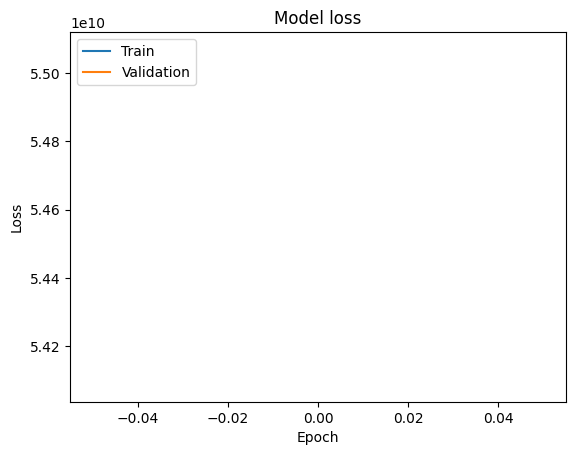

In [40]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [41]:
berty.save('../models/bert_dropout_cali_model.keras')

In [55]:
# Custom object dictionary
custom_model = {'BERTRegression': BERTRegression}

# Load the model with custom objects
berty_pilot = load_model('../models/bert_dropout_cali_model.keras', custom_objects=custom_model)

TypeError: <class '__main__.BERTRegression'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'BERTRegression', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'BERTRegression', 'build_config': {'input_shape': [[None, 230], [None, 230], [None, 230]]}, 'compile_config': {'optimizer': 'adam', 'loss': 'mse', 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.BERTRegression'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of BERTRegression from its config.

Received config={'trainable': True, 'dtype': 'float32'}

Error encountered during deserialization: BERTRegression.__init__() got an unexpected keyword argument 'trainable'

In [49]:
# Example test instance
instance_index = 2
X_test_instance = X_test_scaled.iloc[:instance_index]
print(X_test_instance)

   Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  Population  Households  \
0       1.532001   -0.930638   0.503027      0.121009    0.585984    0.163109   
1      -1.033494    0.978505  -0.302735     -0.328683   -0.280376   -0.325937   

   Latitude  Longitude  Distance_to_coast  Distance_to_LA  \
0  0.829674  -1.145513          -0.431349        0.913629   
1  0.525597  -0.122021           2.729636        0.255790   

   Distance_to_SanDiego  Distance_to_SanJose  Distance_to_SanFrancisco  
0              0.954190            -1.567204                 -1.287059  
1              0.387823            -0.709206                 -0.515092  


In [50]:

true_value = y_test.values[:instance_index]
X_test_instance_with_names = concatenate_columns_with_names(X_test_instance)

In [51]:
print(X_test_instance_with_names[0])

Median_Income 1.5320011109939842 Median_Age -0.9306375345707413 Tot_Rooms 0.5030273656238585 Tot_Bedrooms 0.12100892574299921 Population 0.5859844415073707 Households 0.16310907132478777 Latitude 0.8296735090972744 Longitude -1.1455134755916192 Distance_to_coast -0.4313493337401254 Distance_to_LA 0.9136286731694169 Distance_to_SanDiego 0.9541900126419706 Distance_to_SanJose -1.5672041524835103 Distance_to_SanFrancisco -1.2870590619558007


In [52]:
lime_explanations = berty.explain_lime(X_test_instance_with_names[0])

KeyboardInterrupt: 

In [ ]:
ig_explanations = berty.explain_ig(X_test_instance_with_names[0])

In [98]:

# Tokenize and encode the instance
test_inputs = tokenizer.encode_plus(
    X_test_instance_with_names[0],
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [97]:
# get explanation
explanations = berty_pilot.explain_lime(X_test_instance_with_names[0])

KeyboardInterrupt: 

In [106]:
# Define the predict function for LIME
def predict_function(texts):
    # Tokenize the input texts
    inputs = berty_pilot.tokenizer.batch_encode_plus(
        texts,
        max_length=berty_pilot.max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    # Predict with uncertainty
    outputs = berty_pilot.predict_with_uncertainty([
        inputs['input_ids'],
        inputs['attention_mask'],
        inputs['token_type_ids']
    ])
    return outputs[0].numpy()

In [ ]:
# Print explanations
for exp in explanations:
    print(exp)